# Lista de Exercícios 2 - Elementos de Processamento de Imagens

Prof. Gilson Antonio Giraldi \
Aluno Lorran de Araújo Durães Soares \
Questão 3

3 - Escolha uma base de imagens 𝐷 e converta as imagens para escala de cinza. Separe 𝐷 em dois subconjuntos disjuntos 𝐷𝑡𝑟 e 𝐷𝑡𝑒. 

(a) Calcule o ‘PCA para problemas com pequeno número de amostras’ sobre 𝐷𝑡𝑟. 

(b) Estude o espectro da matriz 𝑅=(1/𝑁)𝑋^TX para realizar a redução de dimensionalidade. 

(c) Aplique o PCA sobre 𝐷𝑡𝑒 e compare a eficiência de compressão com a DCT.

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
np.random.seed(42)
random.seed(42)
from funcoes import PCAAnalysis

In [2]:
image_dir = './fei-database/'
images = []
image_paths = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img = img.resize((260, 360))  
    img_array = np.array(img)
    images.append(img_array)
    image_paths.append(img_path)  

images = np.array(images)
images.shape

(400, 360, 260, 3)

In [3]:
def pre_processamento(images):
    # deixa em tom de cinza
    images_preproces = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

    # vetoriza
    images_preproces = images_preproces.reshape(images.shape[0], -1)

    # # normaliza
    # images_preproces = images_preproces / np.linalg.norm(images_preproces, axis=0)

    return images_preproces

In [4]:
images_preproces = pre_processamento(images)
images_preproces.shape

(400, 93600)

In [5]:
data_train, data_test = train_test_split(images_preproces, test_size=0.2, shuffle=True)

In [6]:
pca_small_size = PCAAnalysis(data_train)

In [7]:
pca_small_size.fit();

Número de componentes que representam 95% da variância dos dados: 99


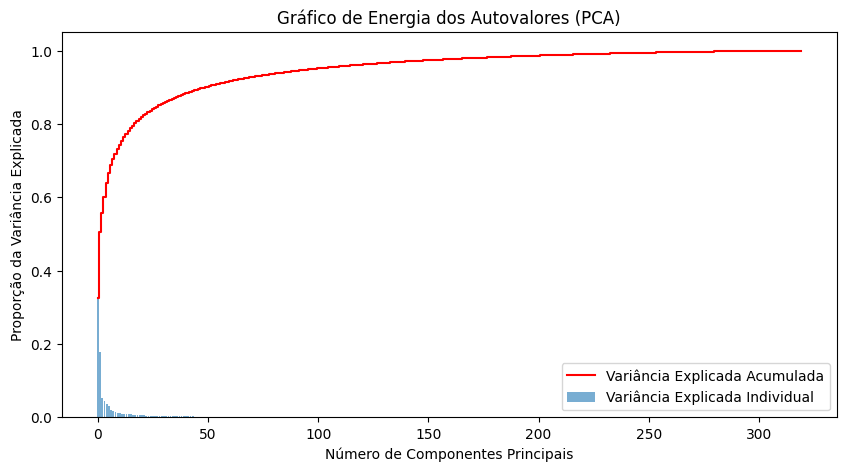

In [8]:
pca_small_size.plot_explained_variance()

In [9]:
pca_small_size.truncate();

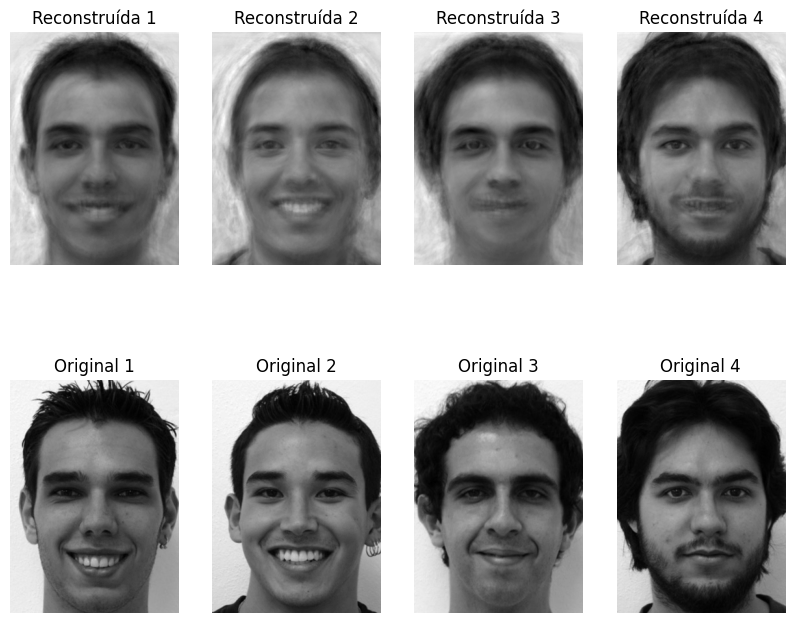

(80, 93600)

In [10]:
data_test_transformed = pca_small_size.transform(data_test)

data_test_reconstructed = pca_small_size.reconstrucion_images(data_test, data_test_transformed)

data_test_reconstructed.shape

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Função para aplicar DCT e compressão
def compress_image_dct(image_path, block_size=8, quantization_matrix=None):
    # Carregar a imagem e convertê-la para escala de cinza
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalizar os valores da imagem
    img = img.astype(np.float32)
    img -= 128  # Ajuste para centramento (valor médio de pixel)
    
    # Dividir a imagem em blocos de 8x8
    h, w = img.shape
    compressed_image = np.zeros_like(img)
    
    # Quantization matrix (exemplo comum)
    if quantization_matrix is None:
        quantization_matrix = np.ones((block_size, block_size)) * 10  # Exemplo de matriz de quantização
    
    # Aplicar DCT em blocos 8x8 e quantização
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = img[i:i+block_size, j:j+block_size]
            
            # Aplicar DCT 2D no bloco
            dct_block = cv2.dct(block)
            
            # Quantizar os coeficientes DCT
            dct_block = np.round(dct_block / quantization_matrix) * quantization_matrix
            
            # Armazenar o bloco comprimido
            compressed_image[i:i+block_size, j:j+block_size] = dct_block
    
    # Reconstruir a imagem com a inversa da DCT
    reconstructed_image = np.zeros_like(img)
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = compressed_image[i:i+block_size, j:j+block_size]
            
            # Aplicar a inversa da DCT 2D
            idct_block = cv2.idct(block)
            
            # Ajuste de valor de pixel (voltar para a faixa original)
            idct_block += 128
            idct_block = np.clip(idct_block, 0, 255)
            reconstructed_image[i:i+block_size, j:j+block_size] = idct_block
    
    return compressed_image, reconstructed_image

# Caminho para a imagem
image_path = './data1/neymar-city.jpg'  # Substitua pelo caminho da sua imagem

# Compressão e reconstrução
compressed, reconstructed = compress_image_dct(image_path, block_size=8)

# Mostrar as imagens original e reconstruída
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(compressed, cmap='gray')
plt.title('Imagem Comprimida (DCT)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed, cmap='gray')
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.show()


ValueError: operands could not be broadcast together with shapes (3,8) (8,8) 